# Introduction:
In this Notebook, I have tried to implement **Text Summarisation** using **Natural Language Processing(NLP)**. This can be used to summarise various articles, reviews, news reports available on different webpages. The text to be summarised is taken from various webpages by using **Web Scrapping**.

There are two types of Text Summarisation techniques:
1. **Extractive Text Summarisation** : It is a method to find the most informative sentences within a large body of text which are used to form a summary.
2. **Abstractive Text Summarisaton** : It is a method to generate concise phrases that are semantically consistent with the large body of text.

We will implement Extractive Text Summarisation in this Notebook.

This notebook contains Text Summarisation based on two Scoring methods namely:
1. **Tf-idf Scoring Method**
2. **Word Embeddings and PageRank Scoring Method**

The second method is implemented using **Google's Word2Vec** and **Stanford's Glove** word embeddings.

Finally, an **All in One Model** is implemented using the two methods above mentioned.

# Importing Libraries

We will use various Python Modules in this Notebook. `nltk` refers to Natural Language Toolkit and helps to perform NLP. `requests` and `BeautifulSoup` are used for getting Text material from webpages.  `networkx` is used for Graph generation process required by PageRank Algorithm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
wordlemmatizer = WordNetLemmatizer()
nltk.download('punkt') #Needs to be downloaded once only

import requests
from bs4 import BeautifulSoup
import operator
import networkx as nx

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\52jai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Below is the code to align all the plots centrally and is not essential for Text summarisation.

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Getting Text from Webpage

Before we start with Tf-idf scoring method, we first need to get Text material. For this purpose we will define a function `get_clean_text` to get the Text to be summarised from the webpage present at given url:


https://indianexpress.com/article/technology/tech-reviews/sennheiser-hd450bt-headphones-review-6424979/

In [3]:
def get_clean_text(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page)
    p_tags = soup.find_all('p', limit = 30)
    p_tags_text = [tag.get_text().strip() for tag in p_tags]
    sentence_list = [sentence for sentence in p_tags_text if not 'Date' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'browser' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'website' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'share' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'subscribe' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'comment' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not '📣' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'download' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'pic' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'read more' in sentence]
    sentence_list = [sentence for sentence in sentence_list if not 'comment' in sentence]
    sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
    final_text = " ".join(sentence_list)
    return final_text, soup

Let us take a look at the Text to be summarised.

In [4]:
url = input("Enter the URL : ")
text, soup = get_clean_text(url)
print(soup.find('h1').get_text(), text, sep = '\n')

Enter the URL : https://indianexpress.com/article/technology/tech-reviews/sennheiser-hd450bt-headphones-review-6424979/
Sennheiser HD450BT review: Great for work, and play
Headphones that offer noise cancellation, great audio quality and clear calling abilities have suddenly become a necessity and are no longer a luxury. With the lockdown making working from our small, often noisy, homes a way of life, more of us will have to spend our money on getting better audio capabilities. This is where the new Sennheiser HD450BT wireless headphones suddenly become relevant. The Sennheiser HD450BT have an over the ear design with soft ear cups and headband. The headset can fold into itself in case you want to carry it in your backpack, not that we are going anywhere these days. The controls are all on the right earcup, packed one after the other in a slightly confusing arch. The power button also switches on the noise cancellation, volume controls and navigation are in a toggle and voice assistan

So, this is a text based upon a product review.

Now, we will build first method to get Text Summarisation, which is fairly simple and does provide us with good results.

# Tf-idf Scoring Method

**Tf-idf** stands for "Term Frequency - Inverse Document Frequency". Tf-idf weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. We will use this weight to get the importance of each sentence in our Text material.

We will undertake following process to implement Tf-idf Scoring for Text Summarisation :
* Text Cleaning
* Sentence Scoring 

Then, we will combine all the functions to get the summary of the Text.

So, let us start with Text Cleaning. We will define two funtions namely `remove_special_characters` and `lemmatize_words` for this purpose.

`remove_special_characters` is used to keep only alphabets and numerical digits in Text and removes any other character.
`lemmatize_words` is used to perform lemmatization which refers to the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the dictionary form.

In [5]:
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [6]:
def lemmatize_words(words):
    lemmatized_words = []
    for word in words:
        lemmatized_words.append(wordlemmatizer.lemmatize(word))
    return lemmatized_words

Now, we move towards getting Sentence scores. We will start with finding the frequency of each word in document using `frequency_word` function.

In [7]:
def frequency_word(words):
    words = [word.lower() for word in words]
    freq_dict = {}
    unique_words = []
    for word in words:
        if word not in unique_words:
            unique_words.append(word)
    for word in unique_words:
        freq_dict[word] = words.count(word)
    return freq_dict

Now, we will define a function that will be used in calculation of sentence scores. `get_noun_verb_sentences` will help us to get only Nouns and Verbs present in a sentence to evaluate its score.

In [8]:
def get_noun_verb_sentence(text):
    pos_tag = nltk.pos_tag(text.split())
    noun_verb_words = []
    for word, tag in pos_tag:
        if tag == "NN" or tag == "NNP" or tag == "NNS" or tag == "VB" or tag == "VBD" or tag == "VBG" or tag == "VBN" or tag == "VBP" or tag == "VBZ":
            noun_verb_words.append(word)
    return noun_verb_words

We need to get **Sentence Scores**. Functions `tf_score`, `idf_score`, `tf_idf_score`, `word_tfidf`, `sentence_score` will  help us to achieve that.

To get the score of a sentence we will sum the product of Tf score and Idf score of each of its words.

In order to get **Tf score**, we find the ratio of number of times a word occurs in the sentence to total number of words in the sentence. 

To get the **Idf score** of a word, we find the ratio of number of sentences in the document to the number of sentences containing that word.

In [9]:
def tf_score(word, sentence):
    freq_sum = 0
    word_frequency_in_sentence = 0
    len_sentence = len(sentence)
    for word_in_sentence in sentence.split():
        if word == word_in_sentence:
            word_frequency_in_sentence = word_frequency_in_sentence + 1
    tf = word_frequency_in_sentence/len_sentence
    return tf

In [10]:
def idf_score(no_of_sentences,word,sentences):
    no_of_sentence_with_req_word = 0
    for sentence in sentences:
        sentence = remove_special_characters(str(sentence))
        sentence = re.sub(r'\d+', '', sentence)
        sentence = sentence.split()
        sentence = [word for word in sentence if word.lower() not in stopwords and len(word)>1]
        sentence = [word.lower() for word in sentence]
        sentence = [wordlemmatizer.lemmatize(word) for word in sentence]
        if word in sentence:
            no_of_sentence_with_req_word = no_of_sentence_with_req_word + 1
    idf = math.log10(no_of_sentences/no_of_sentence_with_req_word)
    return idf

In [11]:
def tf_idf_score(tf, idf):
    return tf*idf

In [12]:
def word_tfidf(freq_dict, word, sentences, sentence):
    word_tfidf = []
    tf = tf_score(word, sentence)
    idf = idf_score(len(sentences), word, sentences)
    tf_idf = tf_idf_score(tf, idf)
    return tf_idf

In [13]:
def sentence_score(sentence, freq_dict, sentences):
    sentence_score = 0
    sentence = remove_special_characters(str(sentence))
    sentence = re.sub(r'\d+', '', sentence)
    noun_verb_sentence = []
    no_of_sentences = len(sentences)
    noun_verb_sentence = get_noun_verb_sentence(sentence)
    for word in noun_verb_sentence:
        if word.lower() not in stopwords and word not in stopwords and len(word) > 1:
            word = word.lower()
            word = wordlemmatizer.lemmatize(word)
            sentence_score = sentence_score + word_tfidf(freq_dict, word, sentences, sentence)
    return sentence_score

Finally, we combine all the functions together to get the Summary.

In [14]:
def get_summary_tfidf(text, retention, model_name):
    tokenized_sentence = []
    sentences_list = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text) # To get the sentences from the Document.
    for sentence in sentences_list:
        tokenized_sentence.append(sentence)
    text = remove_special_characters(str(text))
    text = re.sub(r'\d+', '', text)
    
    tokenized_words_with_stopwords = word_tokenize(text)
    tokenized_words = [word for word in tokenized_words_with_stopwords if word not in stopwords]
    tokenized_words = [word for word in tokenized_words if len(word) > 1]
    tokenized_words = [word.lower() for word in tokenized_words]
    tokenized_words = lemmatize_words(tokenized_words)
    
    word_freq = frequency_word(tokenized_words)
    
    input_user = retention
    no_of_sentences = int((input_user*len(tokenized_sentence))/100)
    
    indx = 1
    sentence_of_importance_dict = {}
    for sent in tokenized_sentence:
        sentence_imp = sentence_score(sent, word_freq, tokenized_sentence)
        sentence_of_importance_dict[indx] = sentence_imp
        indx = indx + 1
    hybrid_dict_1 = sentence_of_importance_dict.copy()
    
    # To get the visual of the Sentence Scores.
    Df = pd.DataFrame(list(sentence_of_importance_dict.items()), index=[i for i in range(0, len(tokenized_sentence))])
    plt.figure(figsize = (12, 10))
    sns.barplot(x = Df[0], y = Df[1], data = Df, color = "Red")
    plt.xlabel("Sentence Number")
    plt.ylabel("Sentence Score")
    plt.title("Score Graph")
    
    sentence_of_importance_dict = sorted(sentence_of_importance_dict.items(), key = operator.itemgetter(1), reverse = True)
    summary = []
    counter = 0
    sentence_no = []
    for important_sentence in sentence_of_importance_dict:
        if counter < no_of_sentences:
            sentence_no.append(important_sentence[0])
            counter = counter + 1
        else:
            break
            
    sentence_no.sort()
    
    iterator = 1
    for sentence in tokenized_sentence:
        if iterator in sentence_no:
            summary.append(sentence)
            if len(summary) == no_of_sentences:
                plt.axhline((sentence_of_importance_dict[no_of_sentences])[1], color = "Green")
        iterator = iterator + 1

    summary = " ".join(summary)
    
    #Printing the Summary.
    print("Summary given by : " + model_name)
    headline = soup.find('h1').get_text()
    print('\033[1m')
    print(headline)
    print('\033[0m')
    print(summary)
    plt.show()
    return hybrid_dict_1

Now, we are ready to get the summary from Tf-idf method.

Percentage of information to retain : 40
Summary given by : Tf-Idf Model

Sennheiser HD450BT review: Great for work, and play

The Sennheiser HD450BT have an over the ear design with soft ear cups and headband. The headset can fold into itself in case you want to carry it in your backpack, not that we are going anywhere these days. The power button also switches on the noise cancellation, volume controls and navigation are in a toggle and voice assistant is another button. Quite a lot to remember. However, it does get a bit hot inside the earcups in the Adelphi heat. But the foam ensures that after a while you forget that you are wearing headphones. Over the past few weeks, I have in a way become addicted to noise cancelling. My part of Delhi is so quiet that you can hear babies cry in faraway apartment blocks and an empty metro train going about its pointless trip sounds like a scene from Speed. But I still need the noise cancelling to be able to cut off the cacophony of home, all sof

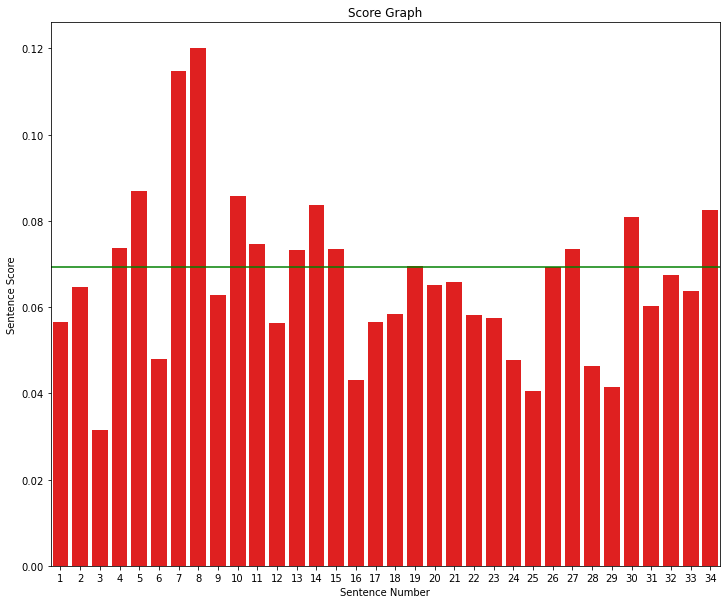

In [15]:
retention = int(input("Percentage of information to retain : "))
hybrid_dict_T = get_summary_tfidf(text, retention, "Tf-Idf Model")

Looks Beautiful! 

Horizontal line in Graph represents the cutoff score for sentences to be used in summary.

Now looking at the summary itself:

We can see it gives quite good results, it explains the various features of the product and gets the overall view of the author. But, it misses out on some important points such as listing of price of the product and author's narrative. Overall, this is a decent enough summary. 

# Word Embeddings and PageRank Scoring Method

Word Embeddings are a method to convert language words into a vector form to apply various mathematical functions on them to extract various features of words. We will use two algorithms to obtain vector representations of words namely:
* Google's Word2Vec and 
* Stanford's Glove

Then, we will evaluate Cosine Similarity of Sentences and pass it on the PageRank Algorithm.

PageRank is an algorithm developed by Google to rank web pages. PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is.

Using PageRank we will implement TextRank which will give us summary we want.

Let us first load both word2vec methods using `gensim` module.

In [16]:
from gensim.models import KeyedVectors
Google_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True) #Google's Word2Vec

In [17]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

from gensim.models import KeyedVectors
filename = 'glove.6B.300d.txt.word2vec'
Stanford_model = KeyedVectors.load_word2vec_format(filename, binary=False) #Stanford's Glove

Now, we move onto getting Sentence Scores like we did in Tf-idf method, only difference is we will finally use Cosine Similarity and PageRank algorithm this time.

In [18]:
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stopwords])
    return sen_new

In [19]:
def get_sentences(text):
    sentences = []
    sentences_list = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    for sentence in sentences_list:
        sentences.append(sentence)
    return sentences

In [20]:
def get_clean_version(sentences):
    clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
    clean_sentences = [s.lower() for s in clean_sentences]
    clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
    return clean_sentences

We will get Sentence Vectors which is something like word2vec but for sentences. Function `get_sentence_vectors` will help us get them.

In [21]:
def get_sentence_vectors(clean_sentences, model_no):
    sentence_vectors = []
    for i in clean_sentences:
        v = np.zeros((300,))
        if len(i) != 0:
            for w in i.split():
                try:
                    v = np.add(v, model_no[str(w)])
                    v1 = (len(i.split())+0.001)
                    v = v/v1
                except:
                    v = np.zeros((300,))
        sentence_vectors.append(v)
    return sentence_vectors

Now, as we have sentence vectors, we will apply Cosine Similarity and PageRank algorithm.

In [22]:
def get_scores(sentence_vectors, sentences):
    sim_mat = np.zeros([len(sentences), len(sentences)])

    from sklearn.metrics.pairwise import cosine_similarity

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))

    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph, max_iter = 200)
    return scores

Finally, we get the summary using above defined functions.

In [23]:
def get_summary_w2v(text, retention, model_no, model_name):
    sentences = get_sentences(text) #To get Sentences from the Text.
    clean_sentences = get_clean_version(sentences) #To get cleaner version.
    sentence_vectors = get_sentence_vectors(clean_sentences, model_no) #To get Sentence Vectors.
    scores = get_scores(sentence_vectors, sentences)
    input_user = retention
    no_of_sentence = int((input_user*len(sentences))/100)
    
    hybrid_dict_2 = scores.copy()
    
    # To get the visual of the Sentence Scores.
    DF = pd.DataFrame(list(scores.items()), index=[i for i in range(len(sentences))])
    plt.figure(figsize = (12, 10))
    sns.barplot(x = DF[0], y = DF[1], data = DF, color = "Red")
    plt.xlabel("Sentence Number")
    plt.ylabel("Sentence Score")
    plt.title("Score Graph")
    
    scores = sorted(scores.items(), key = operator.itemgetter(1), reverse = True)
    
    count = 0
    sentence_no = []
    for ind, score in scores:
        if count < no_of_sentence:
            sentence_no.append(ind)
            count = count + 1
        else:
            break

    sentence_no.sort()
    
    summary = []
    iterator = 1
    for sentence in sentences:
        if iterator in sentence_no:
            summary.append(sentence)
            if len(summary) == no_of_sentence:
                plt.axhline((scores[no_of_sentence])[1], color = "Green")
        iterator = iterator + 1
        
    summary = " ".join(summary)
    
    #Printing the Summary.
    print("Summary given by : " + model_name)
    headline = soup.find('h1').get_text()
    print('\033[1m')
    print(headline)
    print('\033[0m')
    print(summary, "\n")
    plt.show()
    return hybrid_dict_2

So, we are ready to test our both models. Let us start with **Google's Word2Vec Model**.

Percentage of information to retain : 40
Summary given by : Google Word2Vec model

Sennheiser HD450BT review: Great for work, and play

The Sennheiser HD450BT have an over the ear design with soft ear cups and headband. The power button also switches on the noise cancellation, volume controls and navigation are in a toggle and voice assistant is another button. Quite a lot to remember. However, it does get a bit hot inside the earcups in the Adelphi heat. Over the past few weeks, I have in a way become addicted to noise cancelling. The Sennheiser HD450BT has very good noise cancellation, especially when you consider that this is not really a high-end option like we are used to from Sennheiser. It takes away most of the drones like that of the fan and my rickety old AC, but I can still faintly hear my wife go about her Zoom calls and my son watch Avengers for the n-th time. The audio quality is as good as you would expect from Sennheiser — rich, deep and still precise. The HD450BT offer

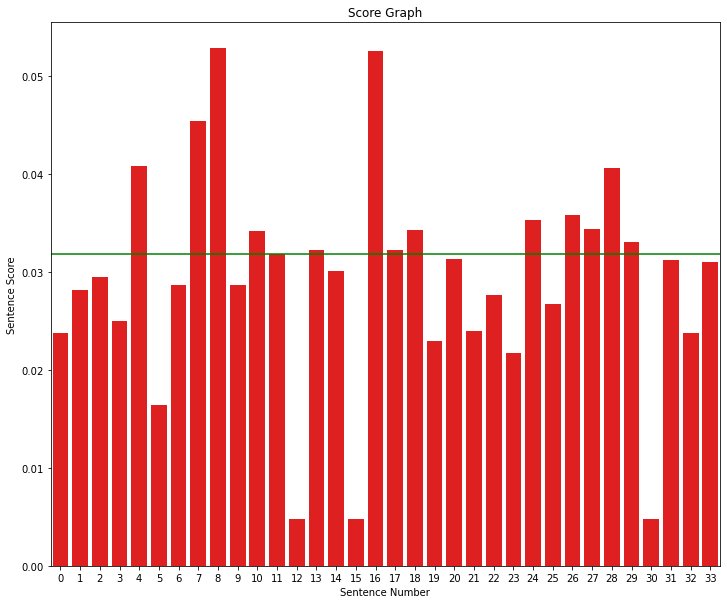

In [24]:
retention = int(input("Percentage of information to retain : "))
hybrid_dict_G = get_summary_w2v(text, retention, Google_model, "Google Word2Vec model")

Looking at the Summary, it is quite good. It heavily emphasises the features of the product, but leaves behind information that might be quite useful such as the Price and the Overall view of the author regarding the product.

Now, let us look at the **Stanford's Glove Model** and find if it is any better than the previous one.

Percentage of information to retain : 40
Summary given by : Stanford's Glove model

Sennheiser HD450BT review: Great for work, and play

The Sennheiser HD450BT have an over the ear design with soft ear cups and headband. The power button also switches on the noise cancellation, volume controls and navigation are in a toggle and voice assistant is another button. Quite a lot to remember. But the foam ensures that after a while you forget that you are wearing headphones. My part of Delhi is so quiet that you can hear babies cry in faraway apartment blocks and an empty metro train going about its pointless trip sounds like a scene from Speed. The Sennheiser HD450BT has very good noise cancellation, especially when you consider that this is not really a high-end option like we are used to from Sennheiser. And when you switch to a Suresh Wadkar singing Seene Mein Jalan, you let his sharp vocal prod you think about our present predicament. The HD450BT offers one-tap access to Siri and Google

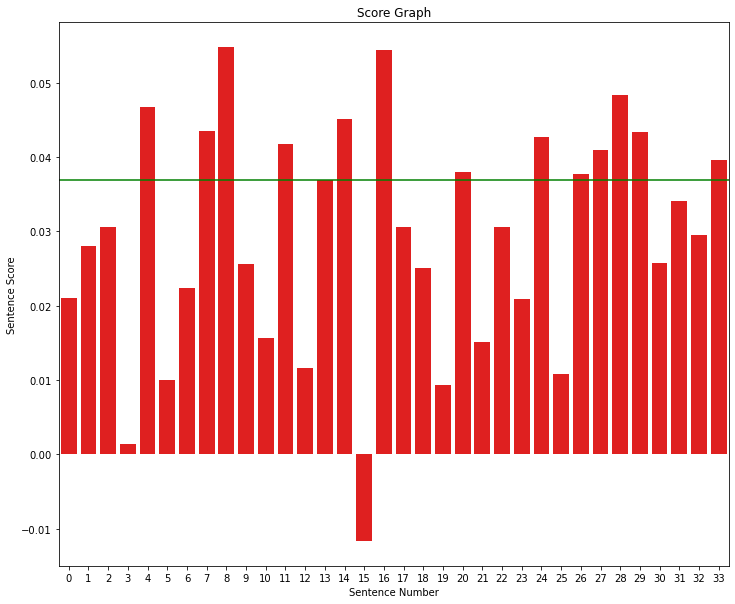

In [25]:
retention = int(input("Percentage of information to retain : "))
hybrid_dict_S = get_summary_w2v(text, retention, Stanford_model, "Stanford's Glove model")

This summary is actually quite better as it combines the features, author's narrative and overall view pretty well.

# All in One Combined Model

Now, finally we will try to make a **Hybrid - ALL in One Model** using all the three methods implemented above to get a combined summary that contains best features of all of them, but removes their shortcomings.

For this Purpose, We will use `hybrid_dict_T`, `hybrid_dict_G`, `hybrid_dict_S` to get the scores of corresponding Sentence Numbers from Tf-idf, Google's Word2Vec and Stanford's Glove Models respectively.

Now, let us write a function `get_hybrid_summary` that combines the three models to get the summary.

In [26]:
def get_hybrid_summary(retention, hybrid_dict, tokenized_sentence, model_name):
    input_user = retention
    no_of_sentences = int((input_user*len(tokenized_sentence))/100)
    
    # To get the visual of the Sentence Scores.
    Df = pd.DataFrame(list(hybrid_dict.items()), index=[i for i in range(0, len(tokenized_sentence))])
    plt.figure(figsize = (12, 10))
    sns.barplot(x = Df[0], y = Df[1], data = Df, color = "Red")
    plt.xlabel("Sentence Number")
    plt.ylabel("Sentence Score")
    plt.title("Score Graph")
    
    hybrid_dict = sorted(hybrid_dict.items(), key = operator.itemgetter(1), reverse = True)
    counter = 0
    summary = []
    sentence_no = []
    for important_sentence in hybrid_dict:
        if counter < no_of_sentences:
            sentence_no.append(important_sentence[0])
            counter = counter + 1
        else:
            break

    sentence_no.sort()
    iterator = 1
    for sentence in tokenized_sentence:
        if iterator in sentence_no:
            summary.append(sentence)
            if len(summary) == no_of_sentences:
                plt.axhline((hybrid_dict[no_of_sentences])[1], color = "Green")
        iterator = iterator + 1

    summary = " ".join(summary)
    #Printing the Summary.
    print("Summary given by : " + model_name)
    headline = soup.find('h1').get_text()
    print('\033[1m')
    print(headline)
    print('\033[0m')
    print(summary)
    plt.show()

Also, we will make a new dictionary to get the sum of all three scores for each sentence.

In [27]:
hybrid_dict = {}
tokenized_sentence = []
sentences_list = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text) # To get the sentences from the Document.
for sentence in sentences_list:
    tokenized_sentence.append(sentence)
    
for i in range(len(tokenized_sentence)):
    val = hybrid_dict_T[i+1] + hybrid_dict_G[i] + hybrid_dict_S[i]
    hybrid_dict[i] = val

Now, let us read the Summary given by the Hybrid model.

Percentage of information to retain : 40
Summary given by : All in One Model

Sennheiser HD450BT review: Great for work, and play

The Sennheiser HD450BT have an over the ear design with soft ear cups and headband. The controls are all on the right earcup, packed one after the other in a slightly confusing arch. The power button also switches on the noise cancellation, volume controls and navigation are in a toggle and voice assistant is another button. Quite a lot to remember. The design makes the headphones very comfortable to be worn over a longer period of time. Over the past few weeks, I have in a way become addicted to noise cancelling. My part of Delhi is so quiet that you can hear babies cry in faraway apartment blocks and an empty metro train going about its pointless trip sounds like a scene from Speed. The Sennheiser HD450BT has very good noise cancellation, especially when you consider that this is not really a high-end option like we are used to from Sennheiser. And when y

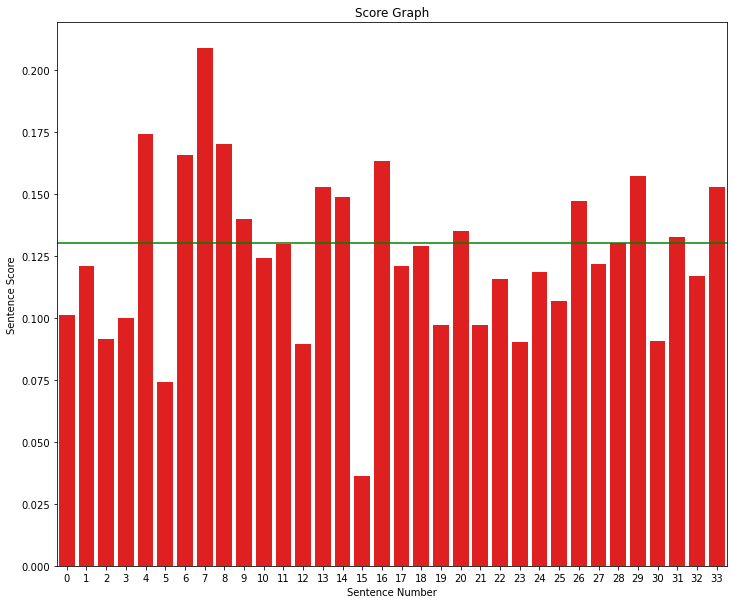

In [28]:
retention = int(input("Percentage of information to retain : "))
get_hybrid_summary(retention, hybrid_dict, tokenized_sentence, "All in One Model")

So, we can see we get a quite well rounded summary which contains features, author's narrative, overall view and price of the product.

# Conclusion : 

We first extracted Text from a web page and then applied three models to get the Summary of that Text.

* First, we applied Tf-idf scoring model to get the summary. It gives good results but may sometimes miss the essence of the article.
* Then, we applied Word Embeddings Models using Google's Word2Vec and Stanford's Glove Word to Vector conversions. Word2Vec conversions gives good results. But, it heavily focussed on one aspect of the review. Glove conversion also gives decent results but sometimes compromised on some features of product.

Finally, A Hybrid - All in One Model was used to get the summary and it gives good results combining all the three models mentioned above.